In [1]:
# Importing necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

# Device Information

In [2]:
# Setting up the device

# device = "mps" if torch.backends.mps.is_available() else "cpu" # Metal Performance Shaders Apple's M1/M2/M3 Chips
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # If CUDA supported GPU available
# device = "cpu" # CPU of the device

print(f"Using device: {device}")

Using device: cuda


# Data Augmentation Transformations

In [3]:
# Define data augmentation transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 Dataset

In [4]:
# Load CIFAR-10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 93403037.40it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model Architecture
Residual Block, Modified ResNet Architecture

In [5]:
# Define residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [6]:
# Modified ResNet model
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 32  # Reduced number of initial channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)  # Reduced initial channels
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)  # Reduced channels
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)  # Reduced channels
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)  # Reduced channels
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
# Define ResNet
def ResNet():
    return ModifiedResNet(BasicBlock, [2,2,2,2])

In [8]:
# Function to count the number of trainable parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
# Define training function with evaluation and plotting
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    model.to(device)  # Move model to the same device as data

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(testloader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        scheduler.step(test_loss)  # Update learning rate scheduler based on test loss

    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curves')
    plt.legend()
    plt.show()

    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Curves')
    plt.legend()
    plt.show()

    # Final evaluation
    print('Final Test Accuracy: {:.4f}'.format(test_acc))

In [10]:
# Instantiate ResNet model
model = ResNet()
model.to(device)  # Move model to the same device as data

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1,

# Model Summary
Total trainable parameters: 2,797,610

In [11]:
# Print model summary
print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

# Training, Testing, Loss & Accuracy Curves, and Saving the Model
Loss Fuction: Cross Entropy Loss <br>
Optimizer: Adam, lr = 0.001, weight decay = 1e-4 <br>
Scheduler: ReduceLROnPlateau <br> <br>

The training loop is executed for 40 epochs, displaying the training and testing loss and accuracy at each epoch. Both training and testing accuracies steadily increase over the epochs, indicating effective training. The loss and accuracy curves are plotted, showing the training and testing loss decreasing while the accuracy increases, which is a positive sign of model learning. <br> <br>

Model saved as "modified_resnet_cifar10_model_40_epochs.pth"

In [12]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250], gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/40], Train Loss: 1.5893, Train Acc: 0.4095, Test Loss: 1.3130, Test Acc: 0.5280
Epoch [2/40], Train Loss: 1.1762, Train Acc: 0.5769, Test Loss: 0.9956, Test Acc: 0.6473
Epoch [3/40], Train Loss: 0.9832, Train Acc: 0.6525, Test Loss: 0.8607, Test Acc: 0.7076
Epoch [4/40], Train Loss: 0.8567, Train Acc: 0.7008, Test Loss: 0.7129, Test Acc: 0.7579
Epoch [5/40], Train Loss: 0.7845, Train Acc: 0.7255, Test Loss: 0.7668, Test Acc: 0.7534
Epoch [6/40], Train Loss: 0.7191, Train Acc: 0.7470, Test Loss: 0.6701, Test Acc: 0.7728
Epoch [7/40], Train Loss: 0.6721, Train Acc: 0.7654, Test Loss: 0.6071, Test Acc: 0.7881
Epoch [8/40], Train Loss: 0.6346, Train Acc: 0.7789, Test Loss: 0.7360, Test Acc: 0.7523
Epoch [9/40], Train Loss: 0.6058, Train Acc: 0.7899, Test Loss: 0.6675, Test Acc: 0.7824
Epoch [10/40], Train Loss: 0.5779, Train Acc: 0.7993, Test Loss: 0.5392, Test Acc: 0.8165
Epoch [11/40], Train Loss: 0.5511, Train Acc: 0.8087, Test Loss: 0.5028, Test Acc: 0.8276
Epoch [12/40], Trai

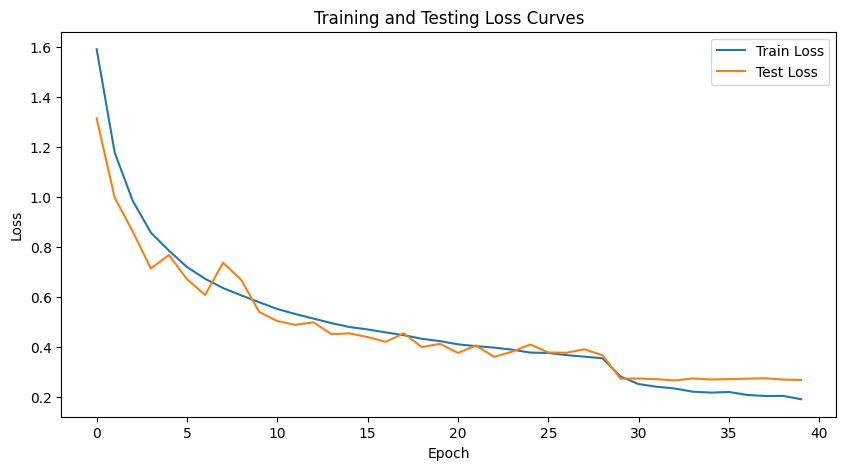

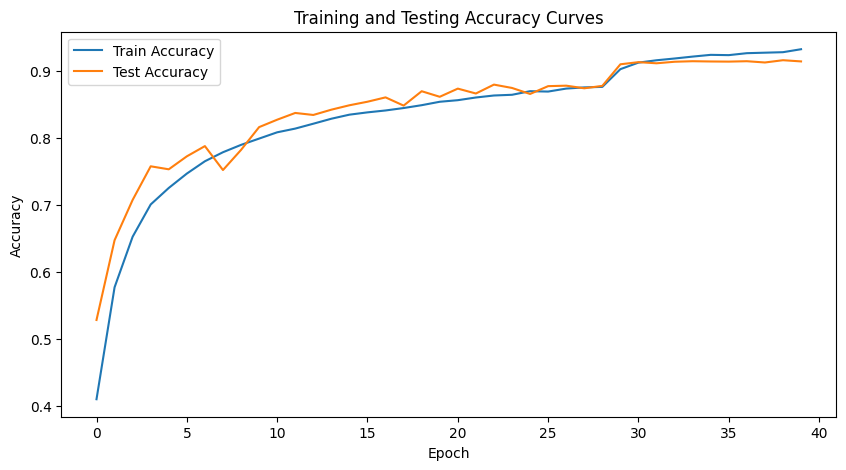

Final Test Accuracy: 0.9148
Model saved successfully!
Accuracy on the dataset: 91.48%


In [13]:
# Training the model
train_model(model, criterion, optimizer, scheduler, num_epochs=40)

# Save the trained model
torch.save(model.state_dict(), 'modified_resnet_cifar10_model_40_epochs.pth')
print('Model saved successfully!')

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy on the dataset: {100 * accuracy:.2f}%')

# Evaluate the model on the test dataset
evaluate_model(model, testloader)

# Performance of the Model
The model achieves a final test accuracy of 91.48%, demonstrating its effectiveness in classifying the CIFAR-10 dataset.

In [14]:
# Instantiate and load the model
'''
model = ResNet()
model.to(device)  # Move model to the same device as data
model.load_state_dict(torch.load('modified_resnet_cifar10_model_40_epochs.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training the model for additional 5 epochs
train_model(model, criterion, optimizer, scheduler, num_epochs=5)
'''

"\nmodel = ResNet18()\nmodel.to(device)  # Move model to the same device as data\nmodel.load_state_dict(torch.load('modified_resnet_cifar10_model_40_epochs.pth'))\n\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)\nscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)\n\n# Training the model for additional 5 epochs\ntrain_model(model, criterion, optimizer, scheduler, num_epochs=5)\n"